In [17]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation_auto_turning_check import *

In [18]:
# # data_file = 'jsons/val_err_wo_lr_decay.json'
# # data_file = 'val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# # data_file = 'jsons/imagenet_dataset0.json'
# # data_file = 'jsons/cifar_all_lr_5e_2.json'
# # data_file = 'jsons/cifar_all_lr_1e_1.json'
# # data_file = 'jsons/cifar_all_lr_8e_2.json'
# with open(data_file) as f:
#     val_acc = json.load(f)
# val_err = 1 - np.array(val_acc)

# num_epochs_between_eval = 20
# min_delta = 5e-4
# patience = 15
# # steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

# smooth_win_size = 55
# whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
# plt.figure()
# plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
# plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

# minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
# print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
# earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
# print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])

<IPython.core.display.Javascript object>


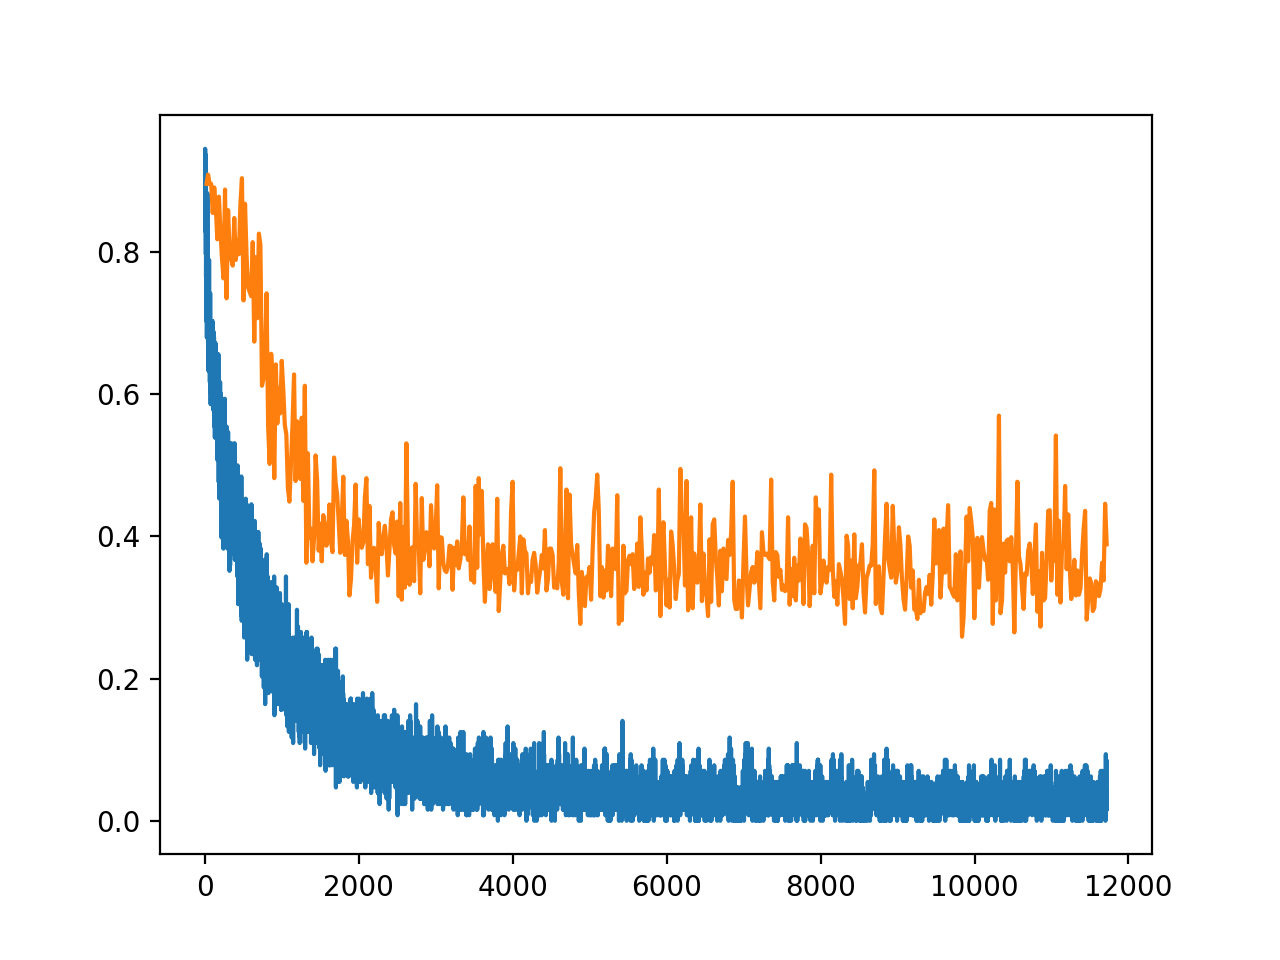

In [19]:
data_file = 'jsons/cifar_subset_train_summary_1_val_20.json'
with open(data_file) as f:
    dict_ = json.load(f)

val_err = np.array(dict_['val_err'])
val_epochs = np.array(dict_['val_epochs'])
train_err = np.array(dict_['train_err'])
train_epochs = np.array(dict_['train_epochs'])

plt.figure()
plt.plot(train_epochs, train_err)
plt.plot(val_epochs, val_err)
# print(len(train_epochs))

In [20]:
# """
# Ignore the first part where evals are more intensive when getting the ground truch early stopping epoch
# """

# # get the begin point after which the num_epochs_between_eval never changes anymore
# e_ref = eval_epochs[0]
# diff = eval_epochs[1] - e_ref
# for i,e in enumerate(eval_epochs[1:]):
#     if e - e_ref == diff:
#         e_ref = e
#     else:
#         switch_point = i + 1
#         switch_epoch = e
#         break
# # print(switch_point,switch_epoch, eval_epochs_[switch_point], eval_epochs_[switch_point-1], eval_epochs_[switch_point+1])

# # delete the replicated values and the final one and the first one
# eval_epochs.pop(switch_point)
# eval_epochs.pop(-1)
# eval_epochs.pop(0)
# val_epochs = np.array(eval_epochs)
# eval_err.pop(switch_point)
# eval_err.pop(-1)
# eval_err.pop(0)
# val_err = np.array(eval_err)
# switch_epoch = val_epochs[switch_point]

# num_epochs_between_eval = val_epochs[switch_point+1] - switch_epoch



num_epochs_between_eval = val_epochs[1] - val_epochs[0]
print(num_epochs_between_eval)
# print(num_epochs_between_eval)
# print(switch_point,switch_epoch, eval_epochs[switch_point], eval_epochs[switch_point-1], eval_epochs[switch_point+1])
min_delta = 5e-4
patience = 8
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55

earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval)
print(earlyStoppingStep)
# print(eval_epochs, train_epochs)

val_epochs[100]

20.0
9100.0


2017.0

In [21]:
# # try other cases

# # data_file = 'jsons/val_err_wo_lr_decay.json'
# # data_file = 'jsons/val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# # data_file = 'jsons/imagenet_dataset0.json'
# # data_file = 'jsons/cifar_all_lr_5e_2.json'
# # data_file = 'jsons/cifar_all_lr_1e_1.json'
# # data_file = 'jsons/cifar_all_lr_8e_2.json'

# with open(data_file) as f:
#     val_acc = json.load(f)

# val_err = 1 - np.array(val_acc)
# num_epochs_between_eval = 20
# min_delta = 5e-4
# patience = 15
# # steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

# smooth_win_size = 55
# whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
# plt.figure()
# plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
# plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

# minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
# print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
# earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
# print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])

# val_epochs = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
# train_epochs = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
# train_err = val_err


In [22]:
'''
common parametes
'''
pred_win_size = 1000 # large enough to include all the points curretly acquired
period = 5
start_point = 5
num_samples = 100
upper_limit = 2e5 # it's acually equivalent to setting no upper limit because 2e5 is larger enough
noise_est_win_size = 100
pure_regression_on_train_end=50
pure_regression_on_val_begin=60
# pure_regression_on_regression_end=1000
# pure_regression_on_original_begin=2000
on_train_pred_win_size=1e6
on_train_period = 100

'''
result list
'''
all_preds = {}
all_errs = {}
all_steps = {}

In [23]:
# '''
# power_regression
# '''
# bnds = ((0, None), (None, 0))
# inits = (1,0)
# left_tail_size = 1000

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err, val_epochs, train_err, train_epochs,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     on_train_pred_win_size = on_train_pred_win_size,
#                                     period = period,
#                                     on_train_period=on_train_period,
# #                                     is_power_linear=False,
#                                     regression_method='power',
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     online_smooth_win_size=1,
#                                     noise_est_win_size = noise_est_win_size,
#                                     pure_regression_on_train_end=pure_regression_on_train_end,
#                                     pure_regression_on_val_begin=pure_regression_on_val_begin,)
# #                                     pure_regression_on_regression_end=pure_regression_on_regression_end,
# #                                     pure_regression_on_original_begin=pure_regression_on_original_begin)

# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power regression: numerical optimization'] = preds
# all_errs['Power regression: numerical optimization'] = errs
# all_steps['Power regression: numerical optimization'] = shifts

In [24]:
# '''
# power + linear regression
# '''
# bnds = ((0, None), (None, 0), (0, None), (None, None))
# inits = (1,0,0,0)

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err, val_epochs, train_err, train_epochs,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     on_train_pred_win_size = on_train_pred_win_size,
#                                     period = period,
#                                     on_train_period=on_train_period,
#                                     regression_method='power_linear',
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     online_smooth_win_size=1,
#                                     noise_est_win_size = noise_est_win_size,
#                                     pure_regression_on_train_end=pure_regression_on_train_end,
#                                     pure_regression_on_val_begin=pure_regression_on_val_begin,)
# #                                     pure_regression_on_regression_end=pure_regression_on_regression_end,
# #                                     pure_regression_on_original_begin=pure_regression_on_original_begin)
# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power + linear regression: numerical optimization'] = preds
# all_errs['Power + linear regression: numerical optimization'] = errs
# all_steps['Power + linear regression: numerical optimization'] = shifts

In [25]:
'''
power_shifted_linear
'''
bnds = ((0, None), (None, 0), (0, None),(None, None))
inits = (1,0,0,0)
left_tail_size = 1000

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err, val_epochs, train_err, train_epochs,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    on_train_pred_win_size = on_train_pred_win_size,
                                    period = period,
                                    on_train_period=on_train_period,
#                                     is_power_linear=False,
                                    regression_method='power_shifted_linear',
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    online_smooth_win_size=1,
                                    noise_est_win_size = noise_est_win_size,
                                    pure_regression_on_train_end=pure_regression_on_train_end,
                                    pure_regression_on_val_begin=pure_regression_on_val_begin,)
#                                     pure_regression_on_regression_end=pure_regression_on_regression_end,
#                                     pure_regression_on_original_begin=pure_regression_on_original_begin)

print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power + shifted linear'] = preds
all_errs['Power + shifted linear'] = errs
all_steps['Power + shifted linear'] = shifts

Global Step: 6
0.0005211800884050931
Predicted Stopping epoch is 793.0. a = 0, b = 0, d^2=0 on training curve
0.0005211800884050931
Global Step: 106
0.0018537249668449524
Predicted Stopping epoch is 4797.0. a = 8.849450333436316, b = -0.6844786539463883, d^2=0 on training curve
0.0018537249668449524
Global Step: 206
0.0021425124574016127
Predicted Stopping epoch is 5561.8. a = 10.391727799085947, b = -0.6670684946890423, d^2=0 on training curve
0.0021425124574016127
Global Step: 306
0.0029853345547471576
Predicted Stopping epoch is 5881.2. a = 11.882076394143885, b = -0.6774422242704673, d^2=0 on training curve
0.0029853345547471576
Global Step: 406
0.0032762483449981956
Predicted Stopping epoch is 6651.6. a = 11.945328248412432, b = -0.6613392408044492, d^2=0 on training curve
0.0032762483449981956
Global Step: 506
0.0037738859732583062
Predicted Stopping epoch is 6883.4. a = 12.645624850286795, b = -0.6628420418137104, d^2=0 on training curve
0.0037738859732583062
Global Step: 606
0.

Predicted Stopping epoch is 6744.474747474747. a = 1.7449867637024847, b = -0.1887283107610565, d^2=1.1903050464129052e-05 on validation curve
Global Step: 5217.0
0.0008094758014769399
Predicted Stopping epoch is 6317.404040404041. a = 1.671797204789986, b = -0.18308772883702423, d^2=6.368298937708604e-06 on validation curve
Global Step: 5317.0
0.0009871239971389922
Predicted Stopping epoch is 6963.060606060606. a = 2.117443061182408, b = -0.2135737115053244, d^2=1.1115282904391593e-05 on validation curve
Global Step: 5417.0
0.0010641665097785888
Predicted Stopping epoch is 7566.89898989899. a = 1.6816757154361033, b = -0.18381402685663312, d^2=3.3207991775311387e-06 on validation curve
Global Step: 5517.0
0.0010479682869868694
Predicted Stopping epoch is 7680.0. a = 2.1683324009649687, b = -0.21546904570765507, d^2=0.0 on validation curve
Global Step: 5617.0
0.001075566124552903
Predicted Stopping epoch is 7494.171717171717. a = 1.5477878985923008, b = -0.17262763157511438, d^2=1.9174

<IPython.core.display.Javascript object>


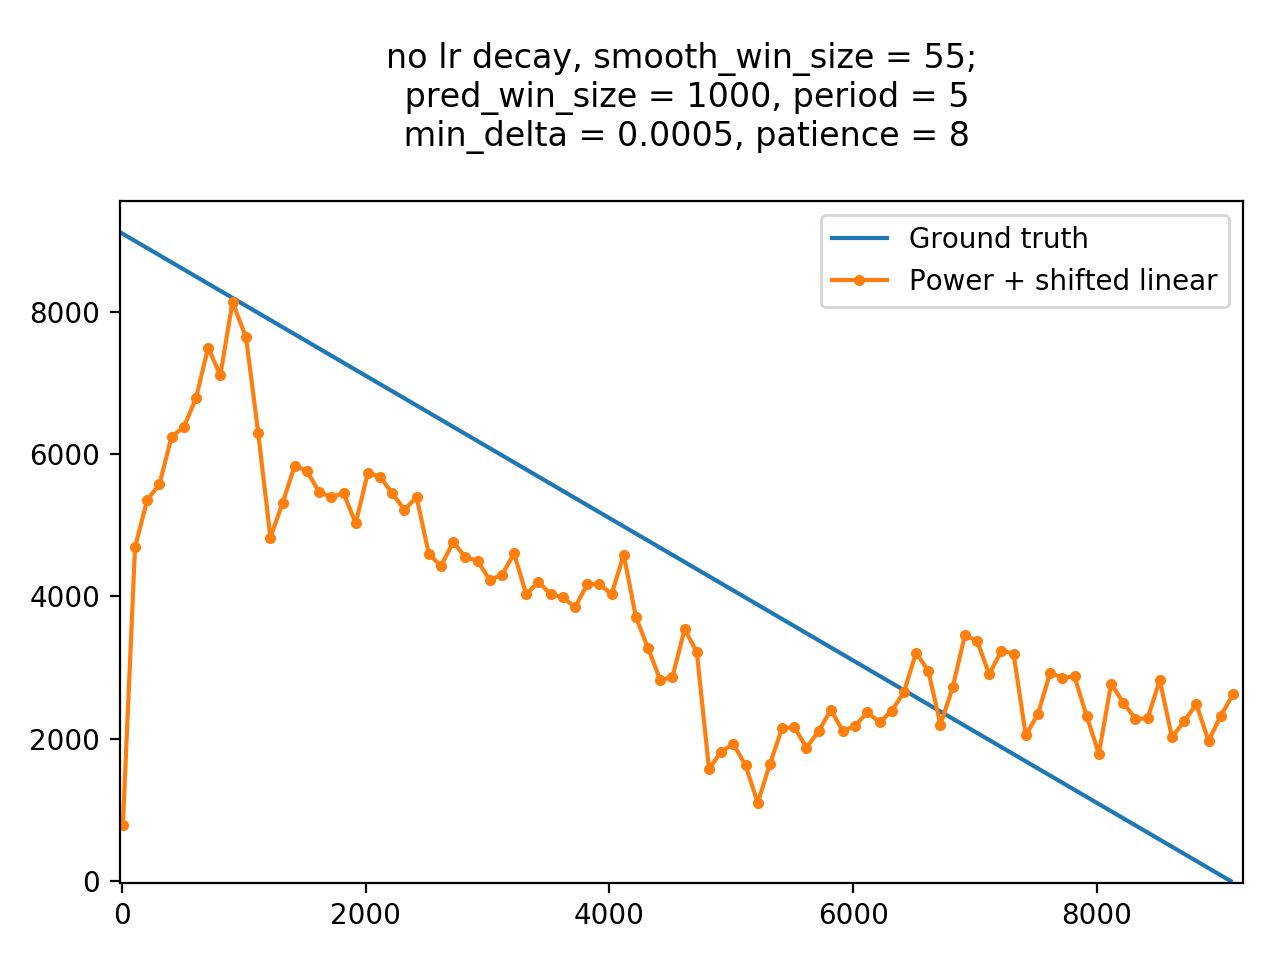

In [26]:
import os

fig = plt.figure()
# ground truth
# x = (start_point+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
x = np.arange(earlyStoppingStep)
plt.plot(x, earlyStoppingStep-x)
legend = ['Ground truth']

# three methods
for alg in all_preds:
#     plt.errorbar(all_steps[alg], np.array(all_preds[alg])-np.array(all_steps[alg]), all_errs[alg], fmt='.-')
    plt.plot(all_steps[alg], np.array(all_preds[alg])-np.array(all_steps[alg]),'.-')
    legend.append(alg)
    
plt.xlim(-20,earlyStoppingStep+100)
plt.ylim(bottom=-20)
plt.legend(legend)
plt.title('no lr decay, smooth_win_size = {4};\n pred_win_size = {0}, period = {1}\n min_delta = {2}, patience = {3}\n '.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

# save the image
dir_ = '/Users/stranot/Desktop/resutls012219/noise_var_no_decay/cifar_subset/'
if not os.path.exists(dir_+'images/'):
    os.makedirs(dir_+'images/')
plt.savefig(dir_ + 'images/min_delta_{:.0e}_patience_{}.png'.format(min_delta, patience))

# store the results
for key in all_preds:
    all_preds[key] = list(int(x) for x in all_preds[key])
    all_errs[key] = list(int(x) for x in all_errs[key])
    all_steps[key] = list(int(x) for x in all_steps[key])
output = {}
output['all_preds'] = all_preds
output['all_errs'] = all_errs
output['all_steps'] = all_steps
if not os.path.exists(dir_+'jsons/'):
    os.makedirs(dir_+'jsons/')
with open(dir_ + 'jsons/min_delta_{:.0e}_patience_{}.json'.format(min_delta, patience), 'w+') as f:
    json.dump(output, f)

<IPython.core.display.Javascript object>


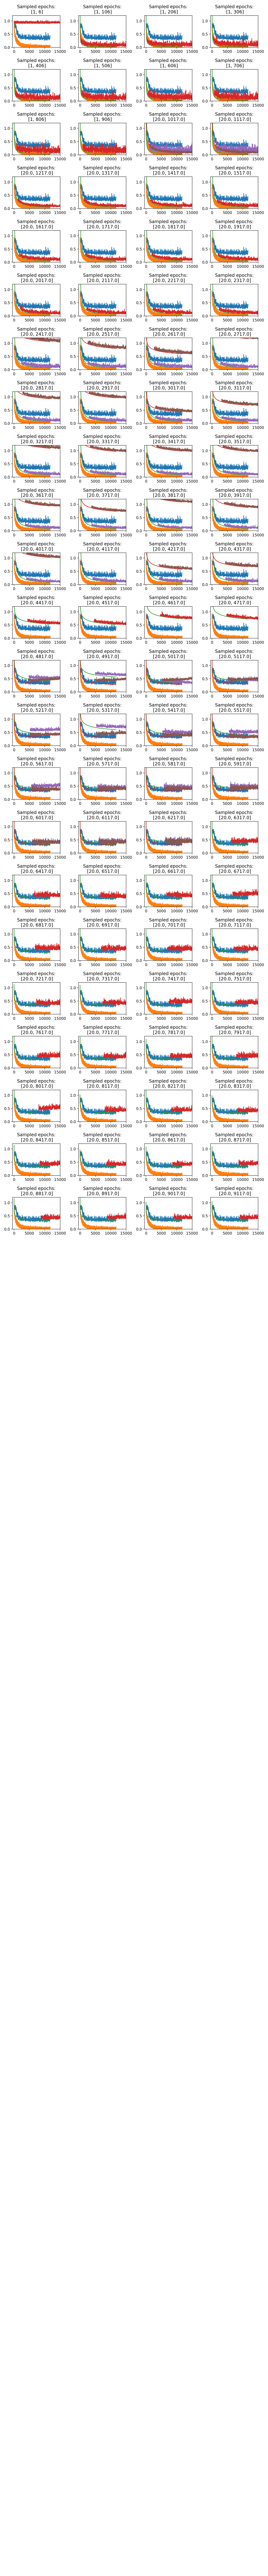

In [27]:
fig = plt.figure(figsize=[10, 96])
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
co = 0
step_size = 1
for i in range(0,len(coeffs),step_size):  
    co += 1
    ax = plt.subplot(48,4, co)
    ax.set_ylim(0, 1.2)
    ax.plot(val_epochs, val_err)
    ax.plot(train_epochs, train_err)
#     print(coeffs[i])
    for j, c in enumerate(coeffs[i]):
#         print(c)
        ax.plot(train_epochs,power_function(train_epochs, c[0], c[1]))
#     if coeffs[i][0] != None:
#         ax.plot(train_epochs,power_function(train_epochs, coeffs[i][0][0], coeffs[i][0][1]))
#     if coeffs[i][1] != None:
#         ax.plot(train_epochs,power_function(train_epochs, coeffs[i][1][0], coeffs[i][1][1]))
#     ax.plot(steps[:len(val_err)],power_function(steps[:len(val_err)], coeffs[i][0], coeffs[i][1]))
    
    e = step_intervals[i][-1]
    s = step_intervals[i][0]
    for j, s_ in enumerate(samples[i]):
        x = np.arange(1,len(s_)+1)*num_epochs_between_eval
        ax.plot(x+e,s_)
#     if len(samples[i][0]) != 0:
#         x = np.arange(1,len(samples[i][0])+1)*num_epochs_between_eval
#         ax.plot(x+e,samples[i][0])
#     if len(samples[i][1]) != 0:
#         x = np.arange(1,len(samples[i][1])+1)*num_epochs_between_eval
#         ax.plot(x+e,samples[i][1])
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,15000)
    
fig.tight_layout()

In [28]:
# '''
# power_regression on smoothed eval_err
# '''
# bnds = ((0, None), (None, 0))
# inits = (1,0)
# left_tail_size = 1000

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err, val_epochs, train_err, train_epochs,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     on_train_pred_win_size = on_train_pred_win_size,
#                                     left_tail_size = left_tail_size,
#                                     weights_type='linear',
#                                     period = period,
#                                     on_train_period=on_train_period,
#                                     is_power_linear=False,
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     online_smooth_win_size=smooth_win_size,
#                                     noise_est_win_size = noise_est_win_size,
#                                     pure_regression_on_train_end=pure_regression_on_train_end,
#                                     pure_regression_on_val_begin=pure_regression_on_val_begin)

# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power regression + smoothed'] = preds
# all_errs['Power regression + smoothed'] = errs
# all_steps['Power regression + smoothed'] = shifts

In [29]:
# '''
# power + linear regression on smoothed eval_err
# '''
# bnds = ((0, None), (None, 0), (None, None))
# inits = (1,0,0)

# # using unsmoothed data; estimate the noise by newest points
# preds, coeffs, shifts, samples, smoothed_samples, CIs, _, step_intervals = powerRegressionIndicator(
#                                     earlyStoppingStep,
#                                     val_err, val_epochs, train_err, train_epochs,
#                                     smooth_win_size,
#                                      num_epochs_between_eval, 
#                                      min_delta,
#                                      patience,
#                                     pred_win_size = pred_win_size,
#                                     on_train_pred_win_size = on_train_pred_win_size,
#                                     left_tail_size = left_tail_size,
#                                     weights_type='linear',
#                                     period = period,
#                                     on_train_period=on_train_period,
#                                     is_power_linear=True,
#                                     bounds=bnds, inits=inits,
#                                     start_point = start_point,
#                                     num_samples=num_samples,
#                                     upper_limit=upper_limit,
#                                     online_smooth_win_size=smooth_win_size,
#                                     noise_est_win_size = noise_est_win_size,
#                                     pure_regression_on_train_end=pure_regression_on_train_end,
#                                     pure_regression_on_val_begin=pure_regression_on_val_begin)
# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Power + linear regression + smoothed'] = preds
# all_errs['Power + linear regression + smoothed'] = errs
# all_steps['Power + linear regression + smoothed'] = shifts

In [30]:
# KF_start_point = 100
# report_period = 20
# init_d = 0
# var_ud = 1e-6

# preds, CIs, _,_,_,steps = KFIndicator(
#                             earlyStoppingStep,
#                             val_err,val_epochs,
#                             smooth_win_size,
#                              num_epochs_between_eval, 
#                              min_delta,
#                              patience,
#                             report_period,
#                             pred_win_size = pred_win_size,
#                             period = period,
#                             init_d = init_d,
#                             var_ud = var_ud,
#     start_point = KF_start_point,
# #                             start_point = start_point,
# #                             KF_start_point = KF_start_point,
#                             num_samples=num_samples,
#                             upper_limit=upper_limit,
#                             noise_est_win_size=noise_est_win_size)

# print(len(preds))
# errs = CIs2errs(CIs)
# all_preds['Kalman filtering'] = preds
# all_errs['Kalman filtering'] = errs
# all_steps['Kalman filtering'] = steps

In [31]:
# index = -1
# a = coeffs[index][0]
# b = coeffs[index][1]
# d = coeffs[index][2]
# steps = rastep_intervals[i][-1]
# step_intervals[i][0]